[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/monografia_modelos/blob/main/01_seleccion_posturas_dataset.ipynb)


# Preparación del dataset Ninapro DB1 - Seleccion de posturas

In [ ]:
try:
    import google.colab 
    !wget --no-cache -O init.py -q https://raw.githubusercontent.com/repos-especializacion-UdeA/monografia_modelos/refs/heads/main/init.py
    from init import init; init(force_download=False)
except ImportError:
    print("Ejecucion del notebook en entorno local")

## Objetivo a desarrollar

Obtener los datos de las posturas de interes.

## Resumen del proceso realizado

1. Carga de las matrices con los datos datos.
2. Segmentación de los datos de acuerdo a las posturas seleccionadas.
3. Almacenamiento de los datos correspondientes a las posturas seleccionadas como matriz 

## 1. Librerias y configuraciones previas


In [1]:
# Verificacion de librerias necesarias antes de empezar
try:
    import scipy.io
    print("La librería 'scipy' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'scipy' no está instalada.")
    print("Instalando 'scipy'...")
    !pip install scipy

try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")
    print("Instalando 'libEMG'...")
    !pip install libemg

try:
    import imblearn
    print("La librería 'imblearn' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'imblearn' no está instalada.")
    print("Instalando 'imblearn'...")
    !pip install imblearn

La librería 'scipy' está instalada y se ha importado correctamente.
La librería 'libEMG' está instalada y se ha importado correctamente.
La librería 'imblearn' está instalada y se ha importado correctamente.


In [7]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Formateo y estilo
# ==============================================================================
from IPython.display import Markdown, display

# Biblioteca scipy y componentes
# ==============================================================================
import scipy.io
from scipy import signal

# Bliblioteca de archivos
# ==============================================================================
import requests
from tqdm import tqdm
import os
import zipfile
import sys

# Biblioteca libemg
# ==============================================================================
from libemg.data_handler import OfflineDataHandler, RegexFilter
from libemg.utils import get_windows
from libemg.feature_extractor import FeatureExtractor

## 2. Funciones

In [3]:
def find_value_ranges(arr, value):
    """
    Encuentra los rangos contiguos donde un valor específico aparece en un arreglo.

    Este método recorre el arreglo de entrada y detecta bloques consecutivos 
    donde el valor coincide con el especificado, retornando las posiciones 
    de inicio y fin de cada uno de esos bloques.

    Parameters
    ----------
    arr : array-like
        Arreglo de entrada, puede ser una lista o un `numpy.ndarray`.
    value : int or float
        Valor que se desea buscar de forma contigua en el arreglo.

    Returns
    -------
    list of tuple of int
        Lista de tuplas (inicio, fin) indicando los índices de cada bloque contiguo 
        donde `value` aparece. Los índices son inclusivos.

    Examples
    --------
    >>> find_value_ranges([1, 2, 2, 3, 2, 2, 2, 4], 2)
    [(1, 2), (4, 6)]

    >>> find_value_ranges([5, 5, 5, 1, 2, 3], 5)
    [(0, 2)]
    """
    arr = np.asarray(arr)
    ranges = []
    in_range = False

    for i, val in enumerate(arr):
        if val == value and not in_range:
            start = i
            in_range = True
        elif val != value and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False

    # Si termina en un bloque del valor
    if in_range:
        ranges.append((start, len(arr) - 1))

    return ranges

In [4]:
def get_exercise_ranges(data, num_exercise, margins=(0, 0)):
    """
    Obtiene el rango global (inicio, fin) del primer al último bloque donde aparece un ejercicio específico.

    La función identifica todos los bloques contiguos en los que el número del ejercicio (`num_exercise`)
    aparece en `data`, y luego retorna un único rango que va desde el inicio del primer bloque 
    hasta el final del último, aplicando márgenes opcionales.

    Parameters
    ----------
    data : array-like
        Arreglo que contiene la codificación de ejercicios (puede ser lista o `numpy.ndarray`).
    num_exercise : int
        Número del ejercicio que se desea localizar.
    margins : tuple of int, optional
        Márgenes (inicio, fin) para ajustar los índices del rango resultante. Por defecto (0, 0).
        El primer valor reduce el índice inicial, el segundo amplía el índice final.

    Returns
    -------
    tuple of int
        Tupla (inicio, fin) representando el rango completo donde aparece el ejercicio,
        ajustado por los márgenes. Ambos índices son inclusivos.

    Notes
    -----
    - Solo se retorna un único rango que cubre desde el primer hasta el último bloque donde aparece el ejercicio.
    - No se retorna una lista de rangos individuales como en `find_value_ranges`.

    Examples
    --------
    >>> get_exercise_ranges([0, 3, 3, 0, 3, 3, 3, 0], num_exercise=3)
    (1, 6)

    >>> get_exercise_ranges([0, 3, 3, 0, 3, 3, 3, 0], num_exercise=3, margins=(1, 1))
    (0, 7)
    """
    indexes = find_value_ranges(data, num_exercise)

    if not indexes:
        raise ValueError(f"El ejercicio {num_exercise} no se encuentra en los datos.")

    initial_index = indexes[0][0]  # Primer índice de inicio
    final_index = indexes[-1][1]  # Último índice de fin

    # Ajustar los índices con los márgenes
    initial_index = max(0, initial_index - margins[0])
    final_index = min(len(data) - 1, final_index + margins[1])

    return initial_index, final_index



In [5]:
def get_multiple_exercise_ranges(data, exercise_numbers, margins=(0, 0)):
    """
    Obtiene los rangos (inicio, fin) para múltiples ejercicios específicos en los datos.

    Esta función recorre una lista de números de ejercicios, localiza su presencia en el arreglo `data`, 
    y construye un diccionario con los rangos correspondientes, ajustados opcionalmente por márgenes.

    Parameters
    ----------
    data : array-like
        Arreglo que contiene la codificación de ejercicios (puede ser lista o `numpy.ndarray`).
    exercise_numbers : list of int
        Lista con los identificadores de los ejercicios que se desean localizar.
    margins : tuple of int, optional
        Márgenes (inicio, fin) para ajustar los índices de los rangos. Por defecto (0, 0).

    Returns
    -------
    dict of int to tuple of int
        Diccionario donde cada clave es el número del ejercicio y el valor asociado es una tupla
        (inicio, fin) con los índices ajustados.

    Raises
    ------
    ValueError
        Si alguno de los ejercicios no se encuentra en `data`.

    Examples
    --------
    >>> data = [0, 1, 1, 0, 2, 2, 0, 3, 3]
    >>> get_multiple_exercise_ranges(data, [1, 2])
    {1: (1, 2), 2: (4, 5)}

    >>> get_multiple_exercise_ranges(data, [1, 4])
    ValueError: El ejercicio 4 no se encuentra en los datos.
    """
    ranges_dict = {}

    # Recorre cada número de ejercicio solicitado
    for num_exercise in exercise_numbers:
        # Usa get_exercise_ranges para obtener el rango ajustado
        ranges_dict[num_exercise] = get_exercise_ranges(data, num_exercise, margins)

    return ranges_dict

In [ ]:
def get_multiple_exercise_ranges(data, exercise_numbers, margins=(0, 0)):
    """
    Obtiene el rango (inicio, fin) para múltiples ejercicios específicos en los datos.

    Para cada número de ejercicio en `exercise_numbers`, la función identifica el bloque total 
    donde dicho ejercicio aparece de forma contigua en `data`, desde su primera ocurrencia 
    hasta la última, y aplica márgenes opcionales para extender o reducir los límites.

    Parámetros
    ----------
    data : array-like
        Arreglo que contiene información codificada sobre ejercicios (por ejemplo, etiquetas de clase o actividad).
    exercise_numbers : list of int
        Lista de identificadores de ejercicios que se desean buscar en los datos.
    margins : tuple of int, optional
        Márgenes (antes, después) que se aplican a los índices de inicio y fin. Por defecto (0, 0).

    Retorna
    -------
    dict of int to tuple of int
        Diccionario donde cada clave es un número de ejercicio, y el valor es una tupla `(inicio, fin)`
        con los índices ajustados donde el ejercicio aparece en el arreglo.

    Raises
    ------
    ValueError
        Si alguno de los ejercicios no se encuentra en los datos.

    Ejemplos
    --------
    >>> data = [0, 1, 1, 0, 2, 2, 0, 1, 1]
    >>> get_multiple_exercise_ranges(data, [1, 2])
    {1: (1, 8), 2: (4, 5)}
    """
    ranges_dict = {}
    for num_exercise in exercise_numbers:
        ranges_dict[num_exercise] = get_exercise_ranges(data, num_exercise, margins)
    return ranges_dict


In [69]:
def get_samples_by_exercises(data, exercise_numbers):
    """
    Extrae las muestras correspondientes a uno o varios ejercicios específicos, aplicando márgenes fijos.

    Para cada número de ejercicio especificado, esta función identifica su rango de aparición 
    en la columna 10 del arreglo `data` (asumida como columna de etiquetas o estímulos) y extrae 
    las muestras correspondientes, incluyendo un margen fijo antes y después de cada bloque.

    Parameters
    ----------
    data : numpy.ndarray
        Matriz de datos completa, donde cada fila representa una muestra y la columna 10 contiene
        los números de ejercicio o etiquetas de estímulo.
    exercise_numbers : list of int
        Lista de identificadores de ejercicios que se desean extraer del conjunto de datos.

    Returns
    -------
    numpy.ndarray
        Subconjunto de `data` que contiene únicamente las muestras correspondientes a los ejercicios 
        especificados, con márgenes aplicados.

    Notes
    -----
    - Los márgenes aplicados a cada bloque son fijos: 50 muestras antes y 50 después.
    - Si varios bloques se solapan, las muestras duplicadas se conservarán.
    - Se usa `np.vstack` para unir los bloques extraídos en un único arreglo.

    Examples
    --------
    >>> data.shape
    (10000, 12)
    >>> get_samples_by_exercises(data, [1, 2]).shape
    (aproximadamente N, 12)
    """
    left_margin = 50   # Número de muestras antes del inicio del ejercicio
    right_margin = 50  # Número de muestras después del final del ejercicio

    # Obtener los rangos de inicio y fin para cada ejercicio solicitado,
    # usando la columna 10 como referencia de etiquetas
    exercise_index = get_multiple_exercise_ranges(data[:, 10], exercise_numbers, (left_margin, right_margin))

    exercise_samples = []

    # Extraer las filas del rango correspondiente a cada ejercicio
    for exercise_number, (start, end) in exercise_index.items():
        exercise_samples.append(data[start:end, :])

    # Combinar todas las muestras en una sola matriz
    return np.vstack(exercise_samples)


## 3. Variables de entorno 

A continuación se configuran los directorios de trabajo

In [88]:
ROOT_DIR =  './'
DATA_DIR =  ROOT_DIR + 'local/data/'
if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)    
RAW_DATA_DIR = DATA_DIR + 'raw'
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
RAW_DATA_DIR_NPY = DATA_DIR + 'raw_numpy'
if not os.path.exists(RAW_DATA_DIR_NPY):
    os.makedirs(RAW_DATA_DIR_NPY)
RAW_SUBSET_DATA_DIR = DATA_DIR + 'raw_subset'
if not os.path.exists(RAW_SUBSET_DATA_DIR):
    os.makedirs(RAW_SUBSET_DATA_DIR)

print("Directorio de trabajo:", ROOT_DIR)
print("Directorio de datos:", DATA_DIR)
print("Directorio de datos crudos:", RAW_DATA_DIR)
print("Directorio de datos crudos (numpy):", RAW_DATA_DIR_NPY)
print("Directorio de datos crudos (subconjunto):", RAW_SUBSET_DATA_DIR)

Directorio de trabajo: ./
Directorio de datos: ./local/data/
Directorio de datos crudos: ./local/data/raw
Directorio de datos crudos (numpy): ./local/data/raw_numpy
Directorio de datos crudos (subconjunto): ./local/data/raw_subset


## 4. Carga y preprocesamiento del dataset original

### 4.1. Carga de datos

Se cargan los datos de cada uno de los 27 usuarios en un diccionario.

In [10]:
# Listar y cargar los archivos .npy del directorio PROCESSED_DATA_DIR
npy_files = [f for f in os.listdir(RAW_DATA_DIR_NPY) if f.endswith('.npy')]

data = {}
for file in npy_files:
    sub_i = file.split('_')[-1].split('.')[0]
    file_path = os.path.join(RAW_DATA_DIR_NPY, file)
    data[sub_i] = np.load(file_path) 
    print(f"Archivo cargado: {file}")

Archivo cargado: data_ex3_subject_1.npy
Archivo cargado: data_ex3_subject_10.npy
Archivo cargado: data_ex3_subject_11.npy
Archivo cargado: data_ex3_subject_12.npy
Archivo cargado: data_ex3_subject_13.npy
Archivo cargado: data_ex3_subject_14.npy
Archivo cargado: data_ex3_subject_15.npy
Archivo cargado: data_ex3_subject_16.npy
Archivo cargado: data_ex3_subject_17.npy
Archivo cargado: data_ex3_subject_18.npy
Archivo cargado: data_ex3_subject_19.npy
Archivo cargado: data_ex3_subject_2.npy
Archivo cargado: data_ex3_subject_20.npy
Archivo cargado: data_ex3_subject_21.npy
Archivo cargado: data_ex3_subject_22.npy
Archivo cargado: data_ex3_subject_23.npy
Archivo cargado: data_ex3_subject_24.npy
Archivo cargado: data_ex3_subject_25.npy
Archivo cargado: data_ex3_subject_26.npy
Archivo cargado: data_ex3_subject_27.npy
Archivo cargado: data_ex3_subject_3.npy
Archivo cargado: data_ex3_subject_4.npy
Archivo cargado: data_ex3_subject_5.npy
Archivo cargado: data_ex3_subject_6.npy
Archivo cargado: data_

Se realizan verificaciones despues de la carga:

In [11]:
len(data)  # Mostrar la cantidad de archivos cargados

27

### 4.2. Inspección de los datos cargados

Con el fin de inspeccionar que se tenga coherencia en los datos cargados, se va a seleccionar un sujeto de muestra (sujeto 1) y se van a realizar las graficas de los datos se este.

In [12]:
INDEX_SUB = '1'
emg_s1 = data[INDEX_SUB][:,0:10]
restimulus_s1 = data[INDEX_SUB][:,10]
rerepetition_s1 = data[INDEX_SUB][:,11]

##### 4.2.1. Grafica de las señales EMG del sujeto seleccionado

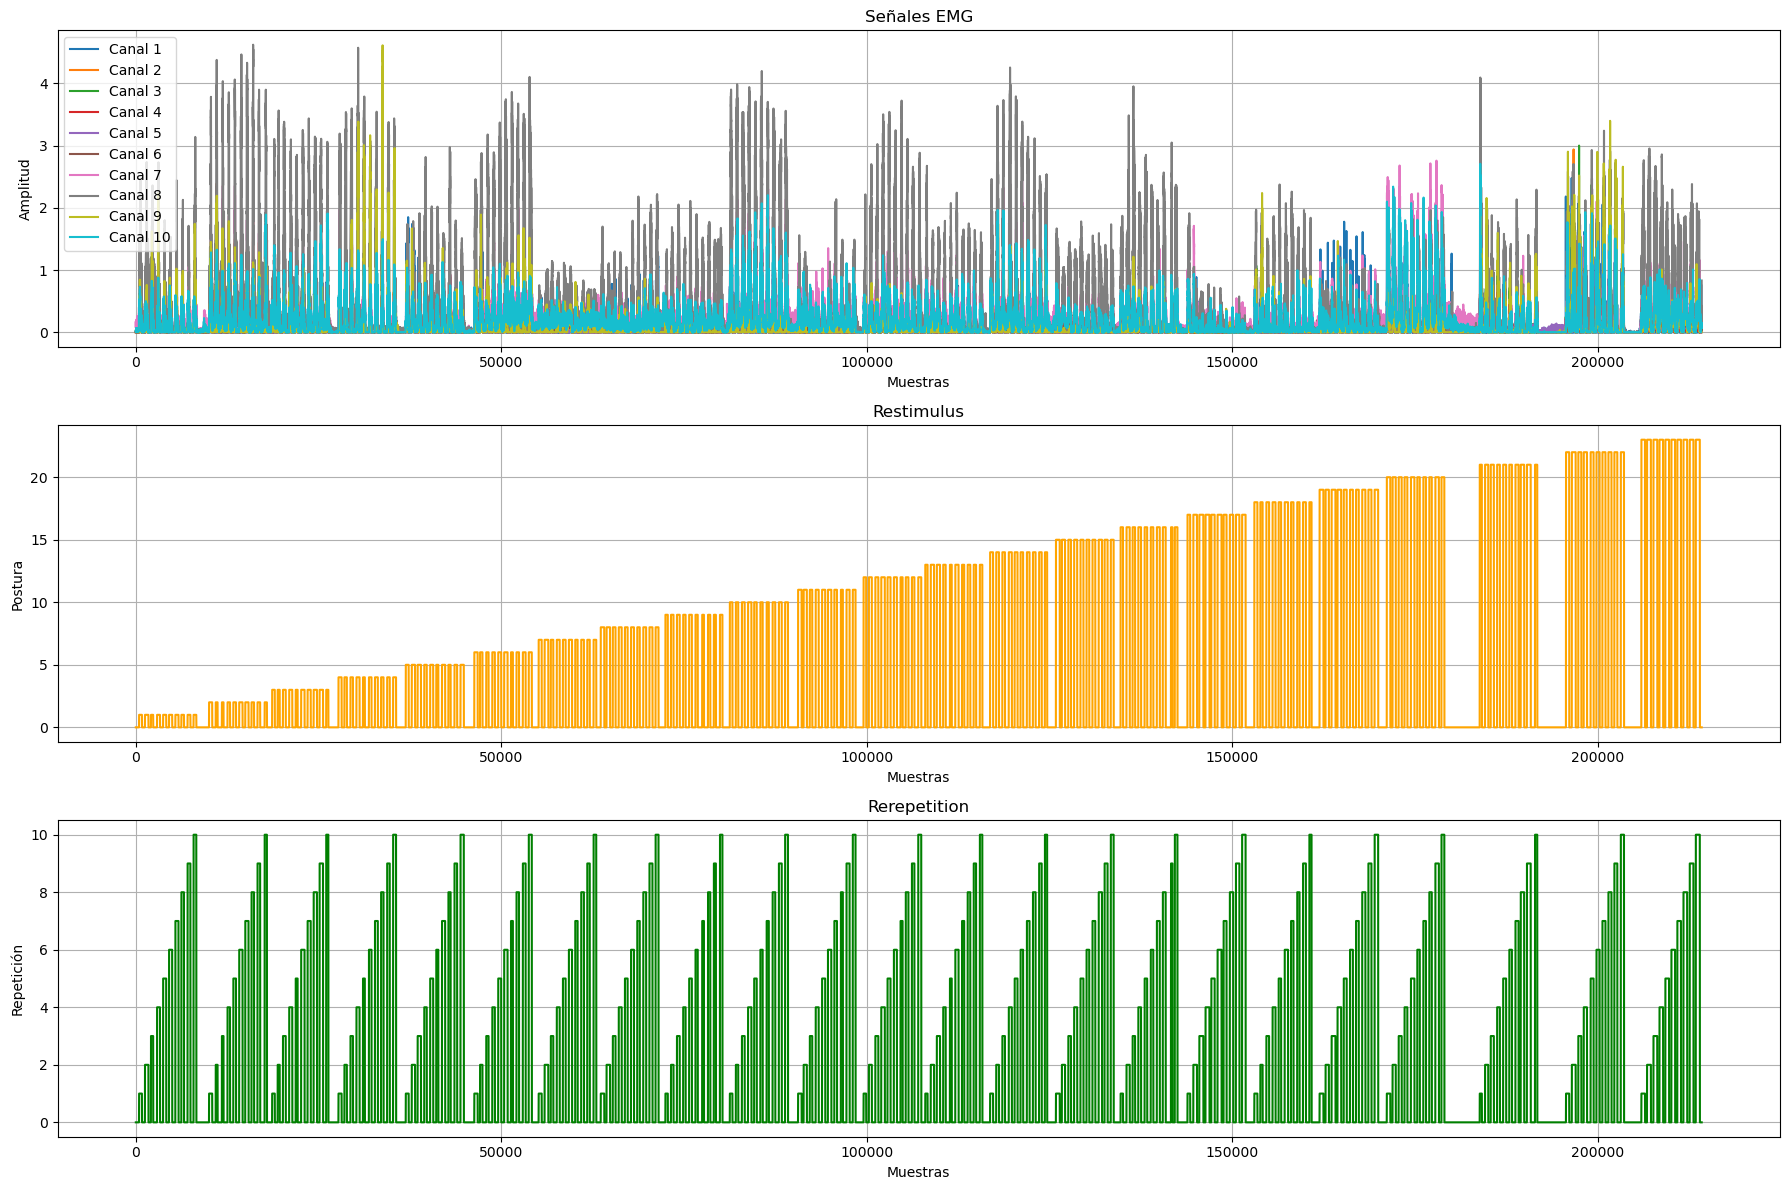

In [13]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

##### 4.2.2. Selección de muestras asociadas a un solo ejercicio

Vamos a seleccionar las muestras asociadas al ejercicio 23:

In [21]:
NUM_POSTURA = 23

# Obtener los rangos de inicio y fin del ejercicio 23
ini_23, end_23 = get_exercise_ranges(restimulus_s1,NUM_POSTURA,(1000,100)) # 1000 puntos a la izquierda y derecha
# Mostrar los rangos
print(f"Rango del ejercicio 23: {ini_23} - {end_23}")

Rango del ejercicio 23: 204973 - 214073


A continuación, se resalta en la grafica la sección asociada a este ejercicio.

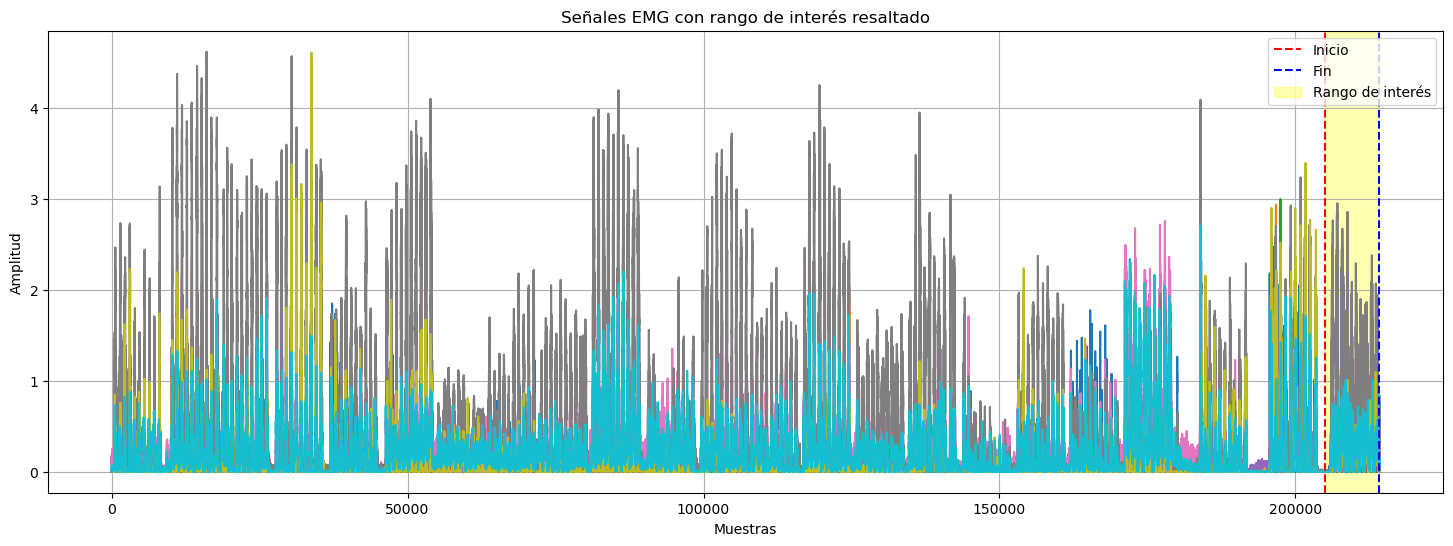

In [22]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    # plt.plot(emg_s1[:, i], label=f'Canal {i+1}')
    plt.plot(emg_s1[:, i])

# Agregar líneas verticales en ini_23 y end_23
plt.axvline(x=ini_23, color='red', linestyle='--', label='Inicio')
plt.axvline(x=end_23, color='blue', linestyle='--', label='Fin')

# Agregar un fondo claro entre las líneas
plt.axvspan(ini_23, end_23, color='yellow', alpha=0.3, label='Rango de interés')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rango de interés resaltado')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

#### 4.2.3. Selección de muestras asociadas a una lista de ejercicios

A continuación se va a generalizar un poco mas el procedimiento permitiendo la elección de varias posturas. Como prueba, se seleccionaron las señales de las posturas 1, 10 y 23 tomando a la izquierda 50 puntos y a la derecha 50

Como prueba, se seleccionaron las señales de las posturas 1 y 23 tomando a la izquierda 50 puntos y a la derecha 50

In [23]:
posturas = [1,10,23]
margen = (50,50)  # 50 muestras a la izquierda y derecha
index_ejercicios_s1 = get_multiple_exercise_ranges(restimulus_s1, posturas, margen)
index_ejercicios_s1

{1: (386, 8322), 10: (81210, 89269), 23: (205923, 214023)}

La siguiente grafica resalta el rango de datos asociado a las posturas elegidas.

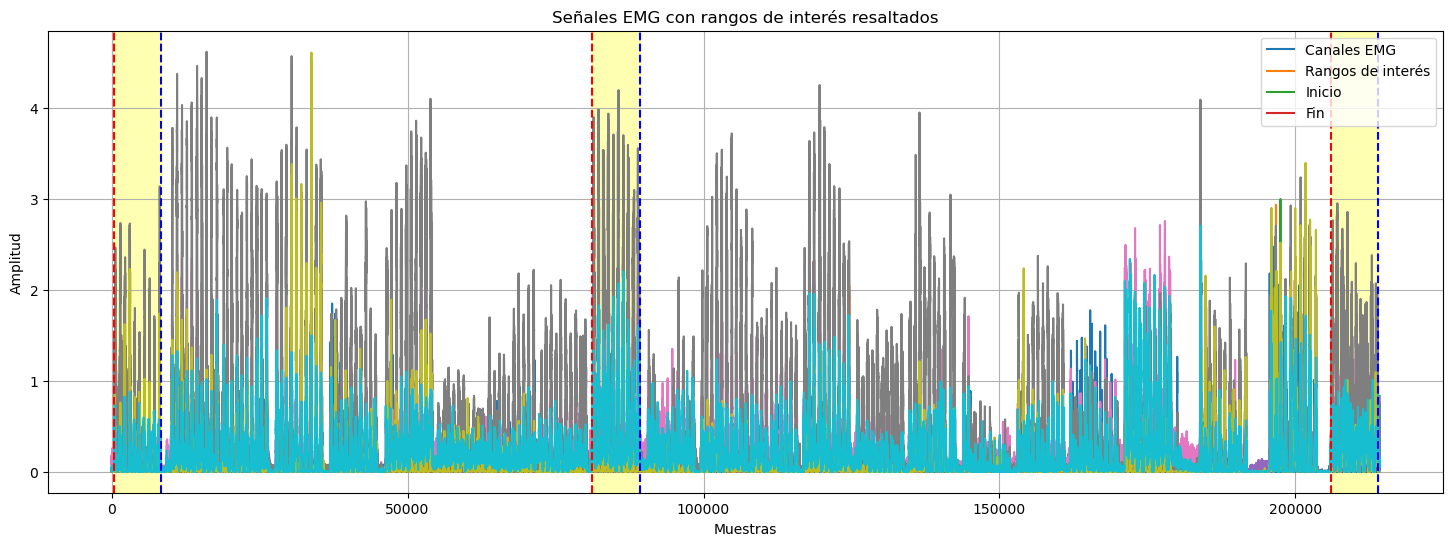

In [24]:
plt.figure(figsize=(18, 6))

# Graficar las señales EMG
for i in range(emg_s1.shape[1]):  # Iterar sobre cada canal de EMG
    plt.plot(emg_s1[:, i])

# Resaltar las regiones entre los rangos encontrados en index_ejercicios_s1
for exercise, (start, end) in index_ejercicios_s1.items():
    plt.axvspan(start, end, color='yellow', alpha=0.3, label=f'Ejercicio {exercise}')
    plt.axvline(x=start, color='red', linestyle='--', label=f'Inicio Ejercicio {exercise}')
    plt.axvline(x=end, color='blue', linestyle='--', label=f'Fin Ejercicio {exercise}')

# Configurar etiquetas y leyenda
plt.title('Señales EMG con rangos de interés resaltados')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(['Canales EMG', 'Rangos de interés', 'Inicio', 'Fin'])
plt.grid(True)

# Mostrar la gráfica
plt.show()

##### 4.2.4. Inspección de los datos de las posturas seleccionadas

Se realizara una inspección rapida de las muestras seleccionadas asociadas a las posturas: 1, 10 y 23

**Postura 1**

In [32]:
EJERCICIO = 1

In [33]:
print("Rango del ejercicio 1:", index_ejercicios_s1[EJERCICIO])

Rango del ejercicio 1: (386, 8322)


In [34]:
end_ex1 = index_ejercicios_s1[1][1]
end_ex1

8322

Grafica de la postura 1 desde la muestra 0

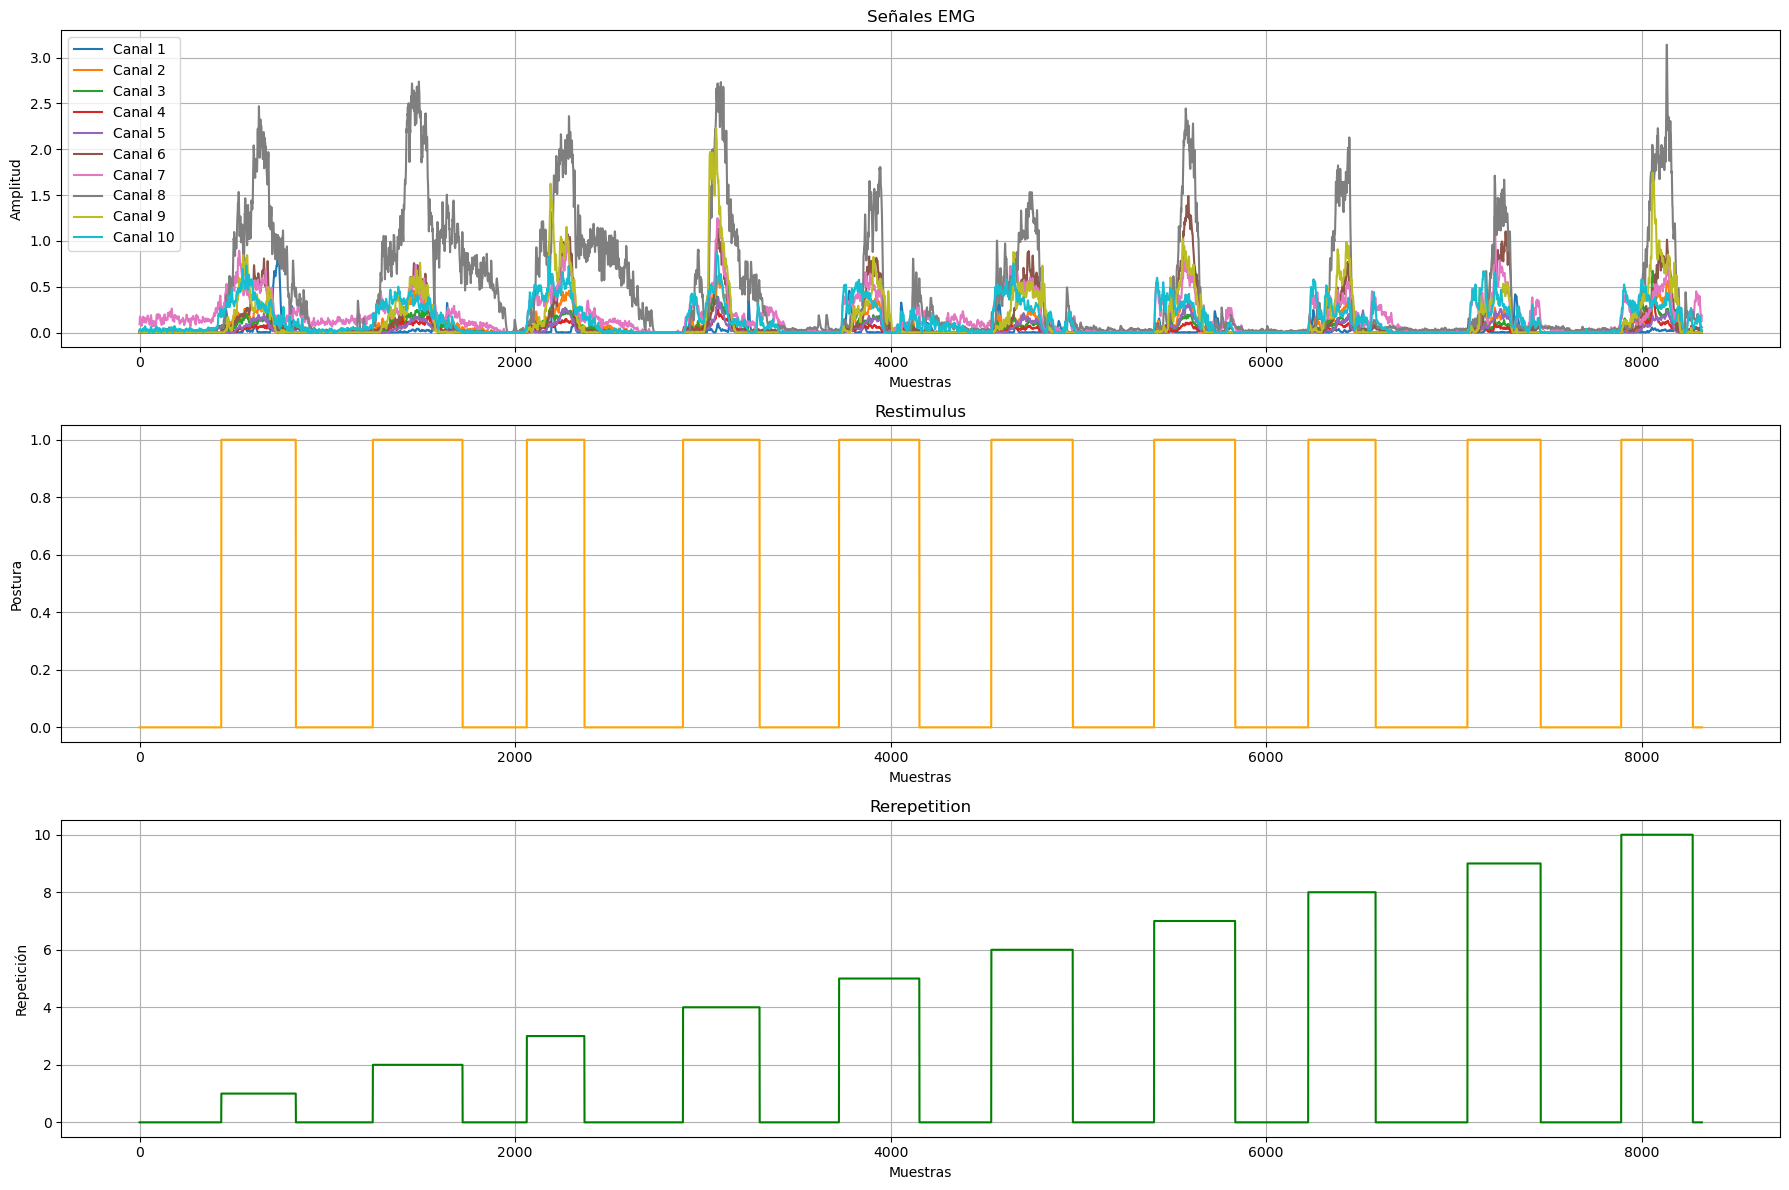

In [35]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1[:end_ex1, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1[:end_ex1], color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1[:end_ex1], color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Ahora se realiza la grafica de la postura 1 dentro del rango obtenido (el que emplea los margenes a la izquierda y a la derecha).

In [36]:
emg_s1_1 = emg_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1], :]
restimulus_s1_1 = restimulus_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1]]
rerepetition_s1_1 = rerepetition_s1[index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1]]

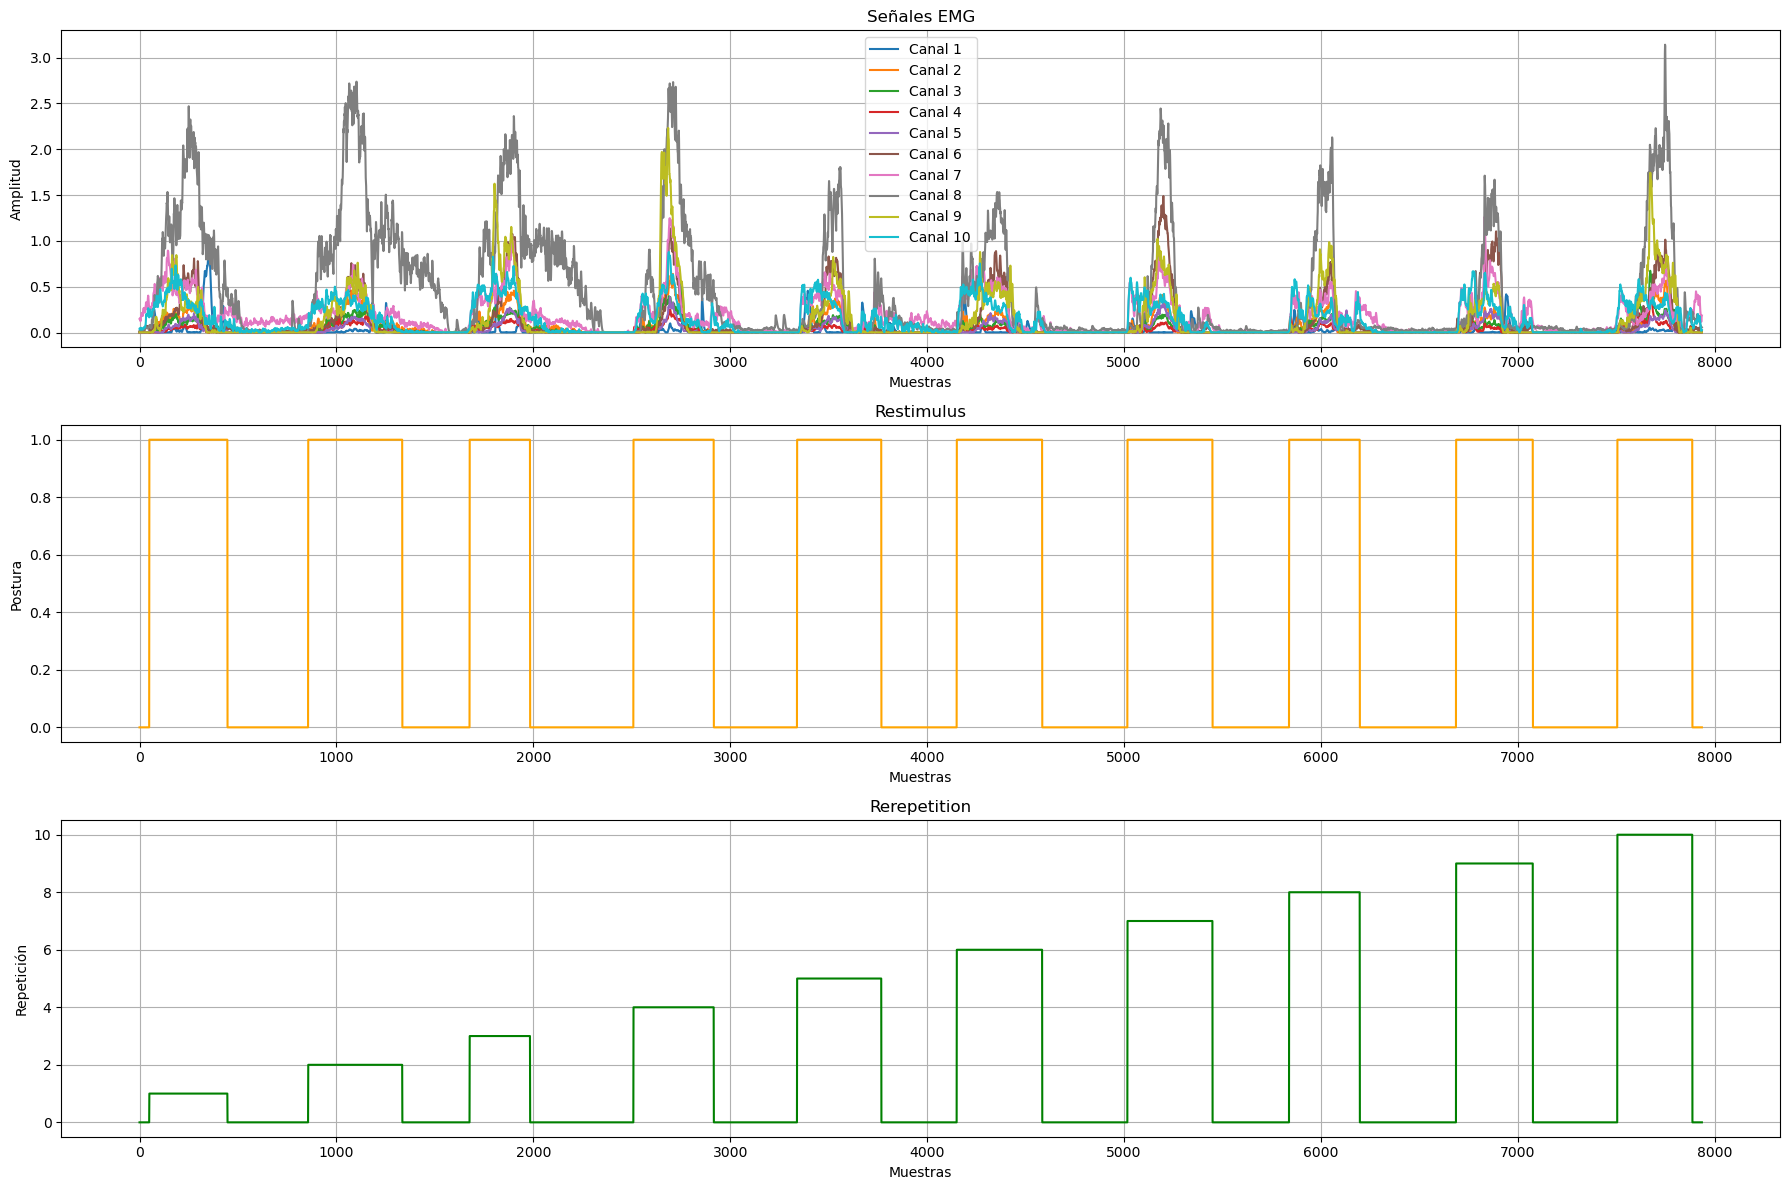

In [29]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1_1.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1_1[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1_1, color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1_1, color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

> **Observación**: 
> 
> En la ultima grafica se puede ver que la grafica toma 50 muestras en los extremos.

**Portura 10**

In [47]:
EJERCICIO = 10
index_ejercicios_s1[EJERCICIO]

(81210, 89269)

In [48]:
emg_s1_10 = emg_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1], :]
restimulus_s1_10 = restimulus_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1]]
rerepetition_s1_10 = rerepetition_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1]]

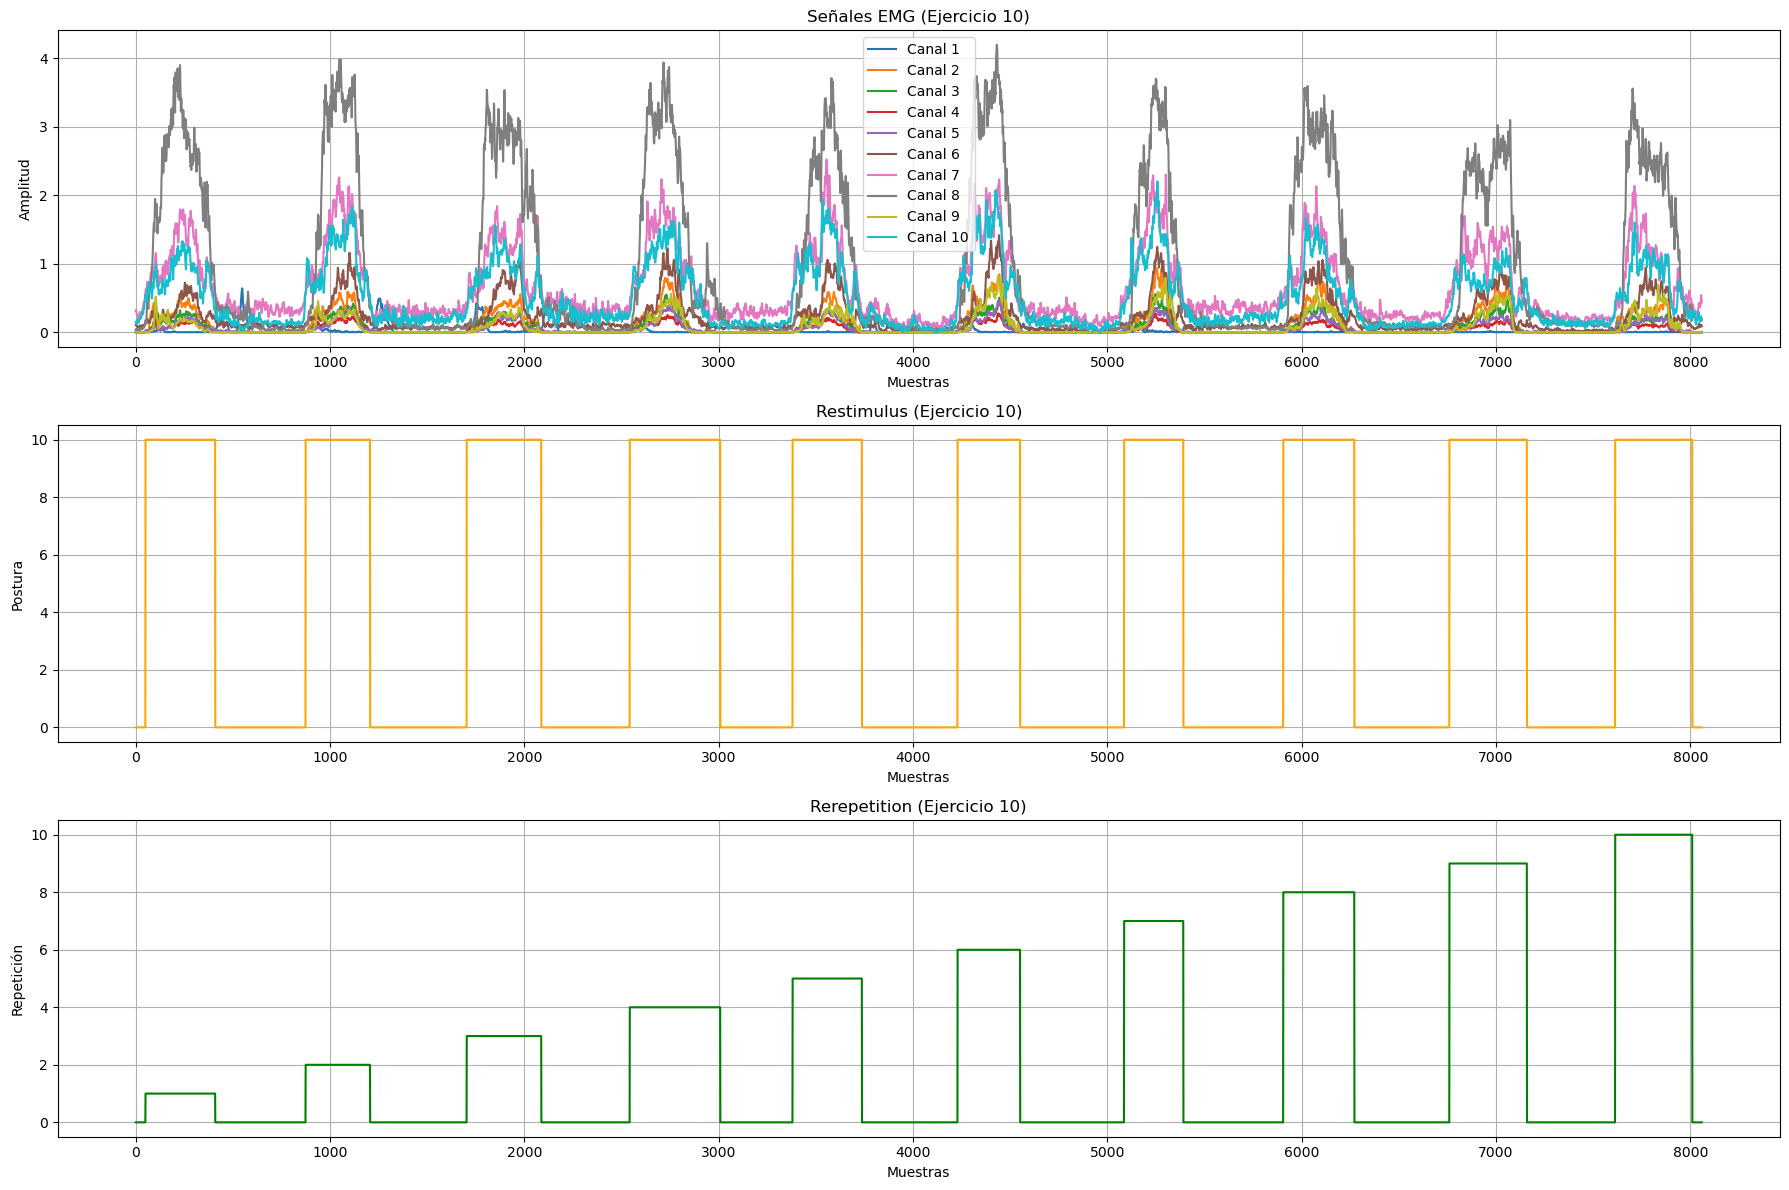

In [50]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1_10.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1_10[:, i], label=f'Canal {i+1}')
plt.title(f'Señales EMG (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1_10, color='orange')
plt.title(f'Restimulus (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1_10, color='green')
plt.title(f'Rerepetition (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

**Postura 23**

In [51]:
EJERCICIO = 23
index_ejercicios_s1[23]

(205923, 214023)

In [43]:
emg_s1_23 = emg_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1], :]
restimulus_s1_23 = restimulus_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1]]
rerepetition_s1_23 = rerepetition_s1[index_ejercicios_s1[EJERCICIO][0]:index_ejercicios_s1[EJERCICIO][1]]

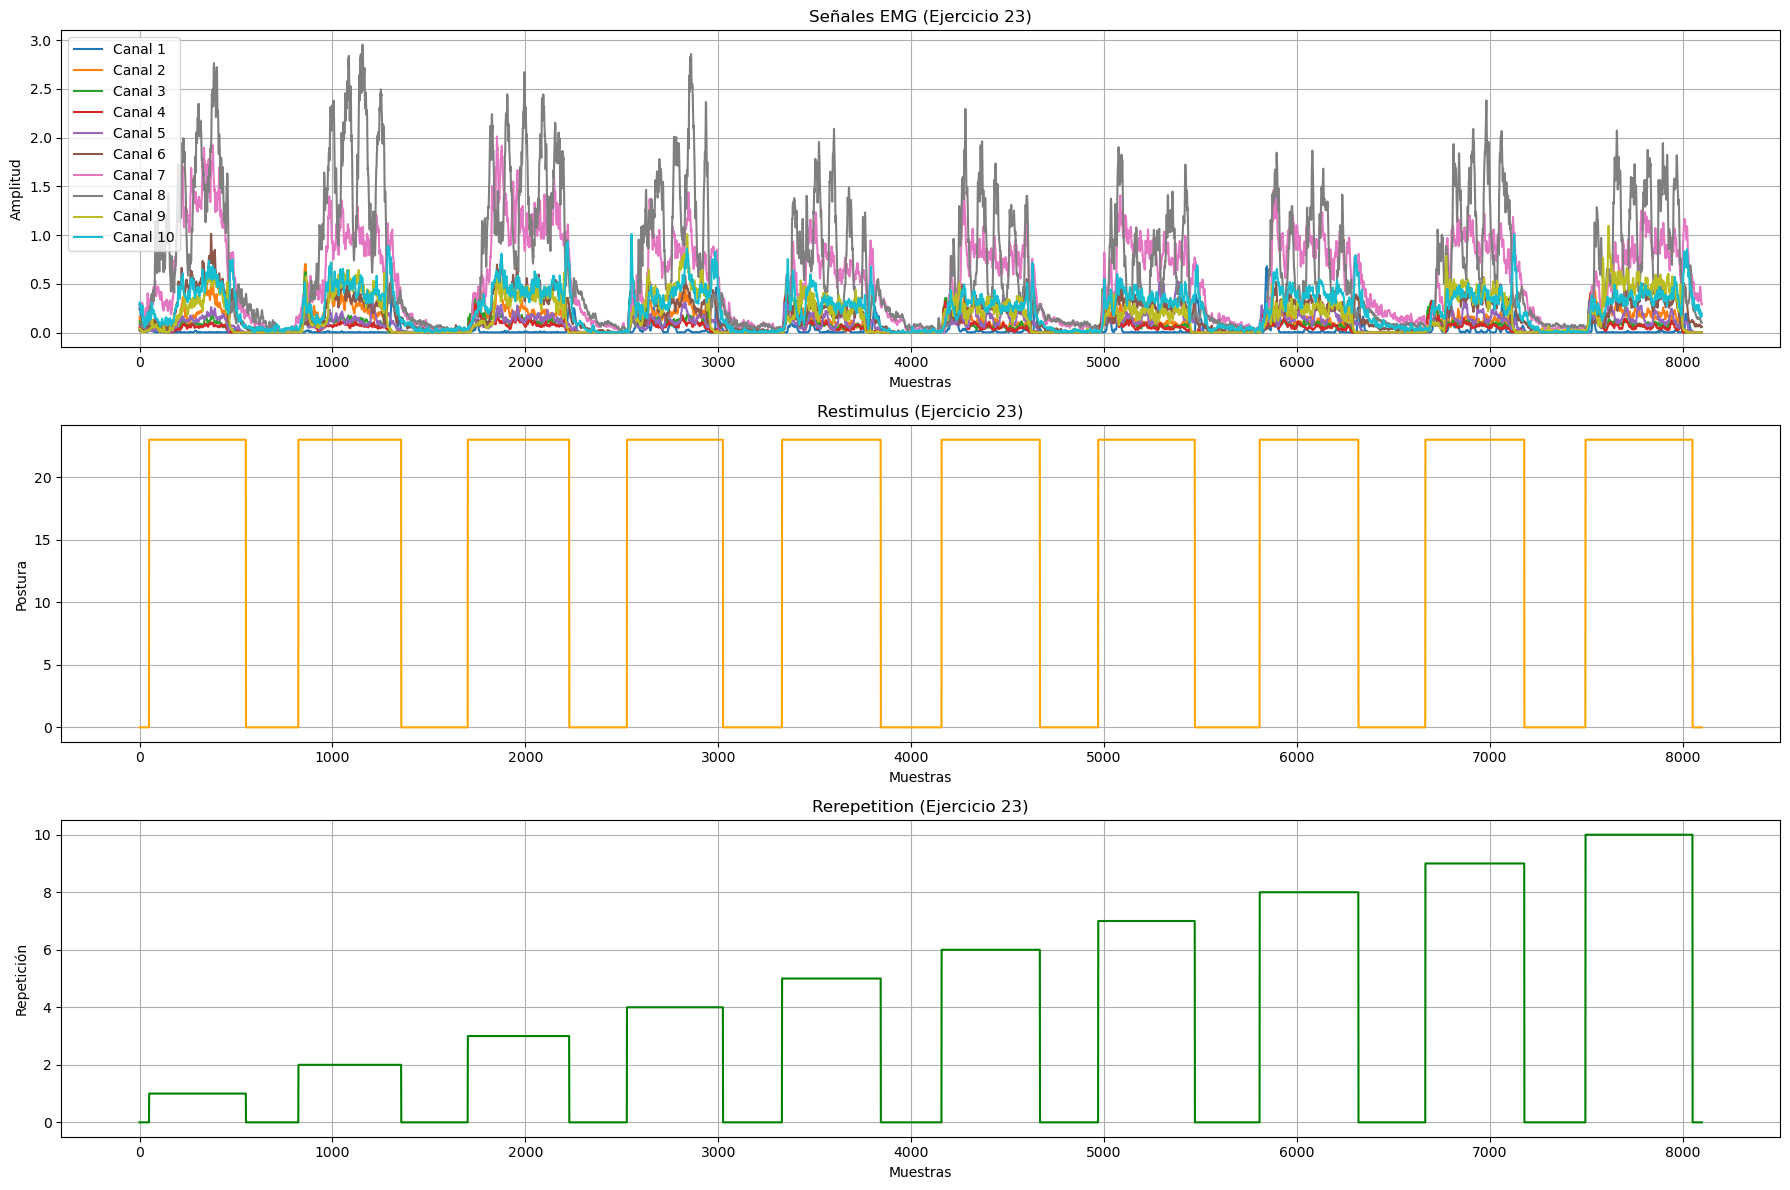

In [53]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_s1_23.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_s1_23[:, i], label=f'Canal {i+1}')
plt.title(f'Señales EMG (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_s1_23, color='orange')
plt.title(f'Restimulus (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_s1_23, color='green')
plt.title(f'Rerepetition (Ejercicio {EJERCICIO})')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

##### 4.2.5. Combinación de las posturas seleccionadas

A continuación, se realiza la combinación de las posturas seleccionadas como un solo dentro de una sola matriz. 

Tamaño de datos postura 1

In [60]:
data_s1_1 = data[INDEX_SUB][index_ejercicios_s1[1][0]:index_ejercicios_s1[1][1], :]
data_s1_1.shape  # Mostrar la forma de los datos cargados

(7936, 12)

In [64]:
data_s1_10 = data[INDEX_SUB][index_ejercicios_s1[10][0]:index_ejercicios_s1[10][1], :]
data_s1_10.shape  # Mostrar la forma de los datos cargados

(8059, 12)

Tamaño de datos postura 23

In [65]:
data_s1_23 = data[INDEX_SUB][index_ejercicios_s1[23][0]:index_ejercicios_s1[23][1], :]
data_s1_23.shape  # Mostrar la forma de los datos cargados

(8100, 12)

Combinación de las posturas.

In [66]:
# Apilar las matrices data_s1_1 y data_s1_23
data_combined = np.vstack((data_s1_1, data_s1_10, data_s1_23))
data_combined.shape  # Mostrar la forma de la matriz combinada

(24095, 12)

Se seleccionan los grupos de datos asociados a los diferentes tipos de señales.

In [67]:
emg_combined = data_combined[:, 0:10]
restimulus_combined = data_combined[:, 10]
rerepetition_combined = data_combined[:, 11]

**Grafica con la combinación de las señales 1,10 y 23 seleccionadas**

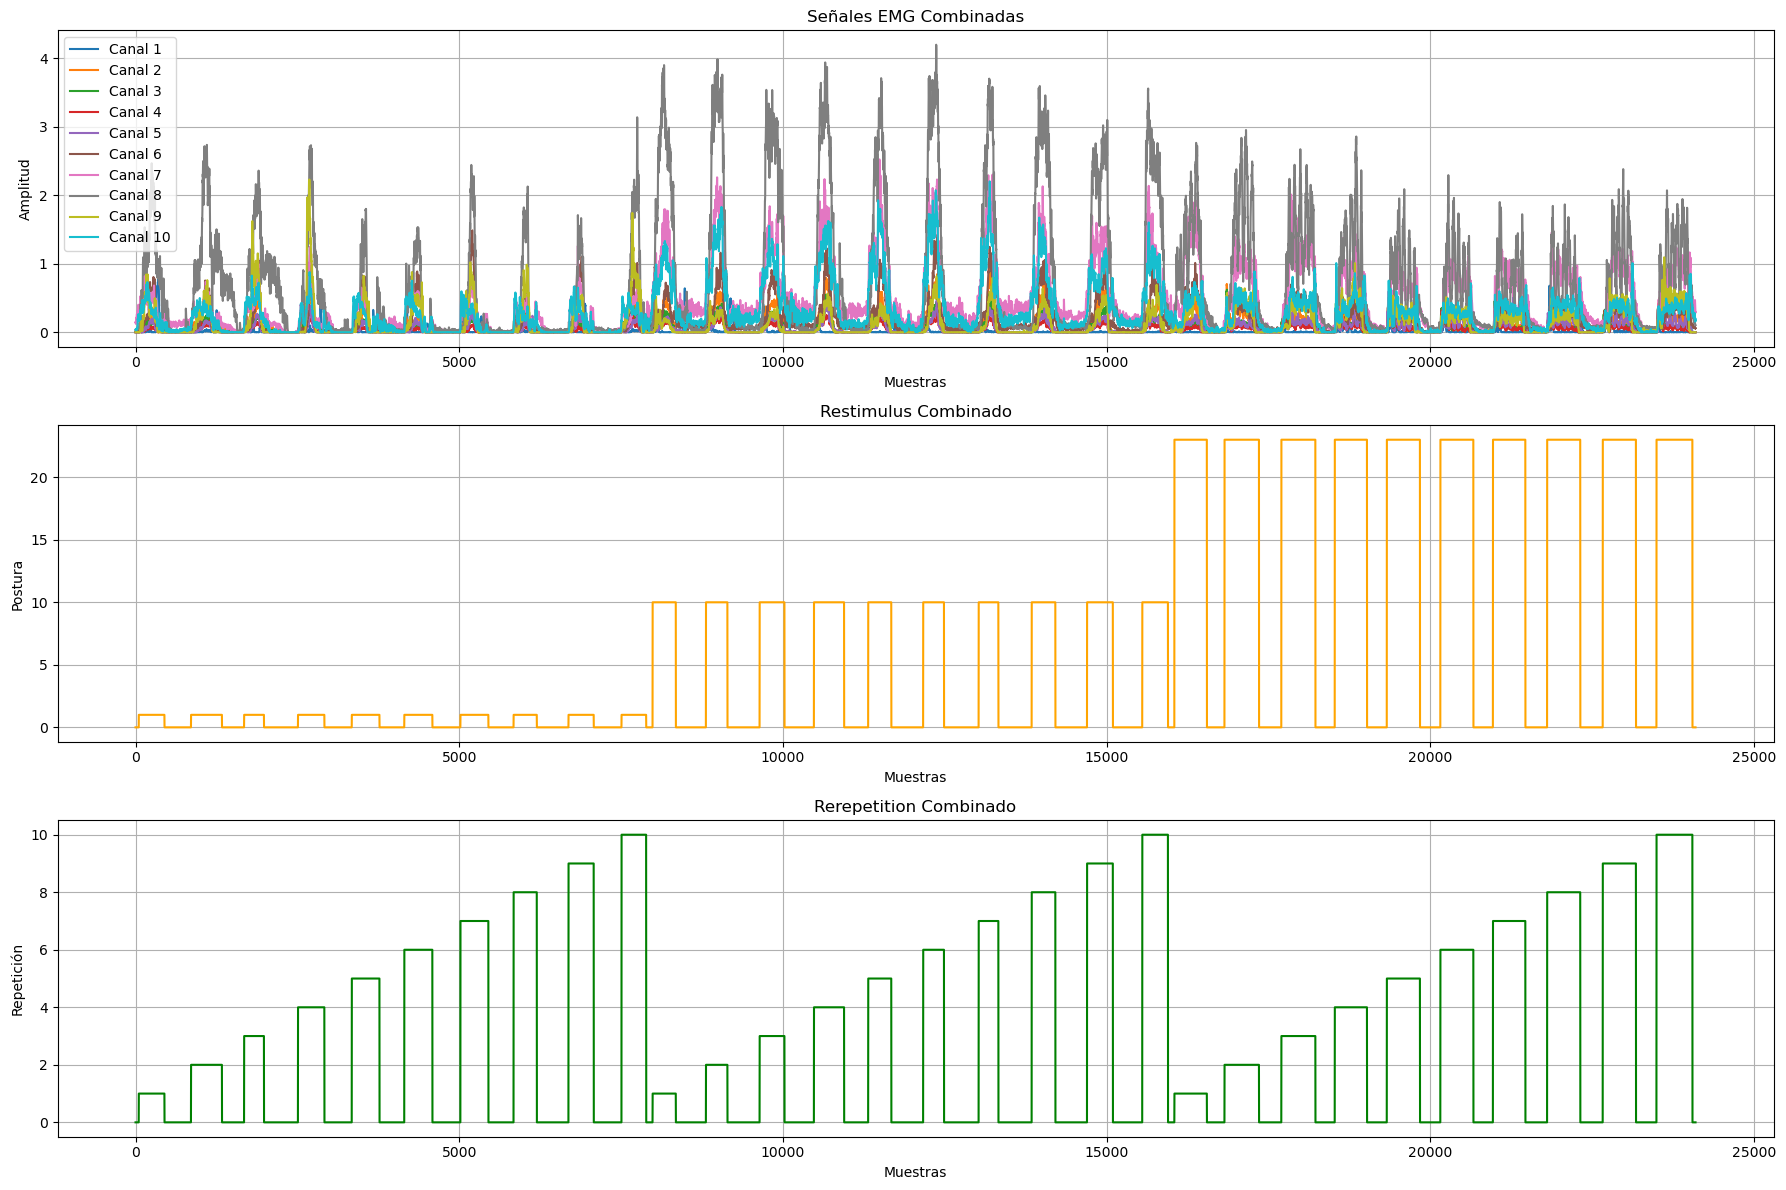

In [68]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals
plt.subplot(3, 1, 1)
for i in range(emg_combined.shape[1]):  # Iterate over each EMG channel
    plt.plot(emg_combined[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG Combinadas')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus
plt.subplot(3, 1, 2)
plt.plot(restimulus_combined, color='orange')
plt.title('Restimulus Combinado')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition
plt.subplot(3, 1, 3)
plt.plot(rerepetition_combined, color='green')
plt.title('Rerepetition Combinado')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

##### 4.2.6. Generalización del procedimiento de combinación de datos

La siguiente función generaliza el procedimiento.

In [77]:
data[INDEX_SUB].shape  # Mostrar la forma de los datos cargados

(214236, 12)

In [78]:
posturas

[1, 10, 23]

In [79]:
data_s1_ex_1_10_23 = get_samples_by_exercises(data[INDEX_SUB], posturas)  # Obtener muestras de los ejercicios 1 y 23

In [80]:
data_s1_ex_1_10_23.shape

(24095, 12)

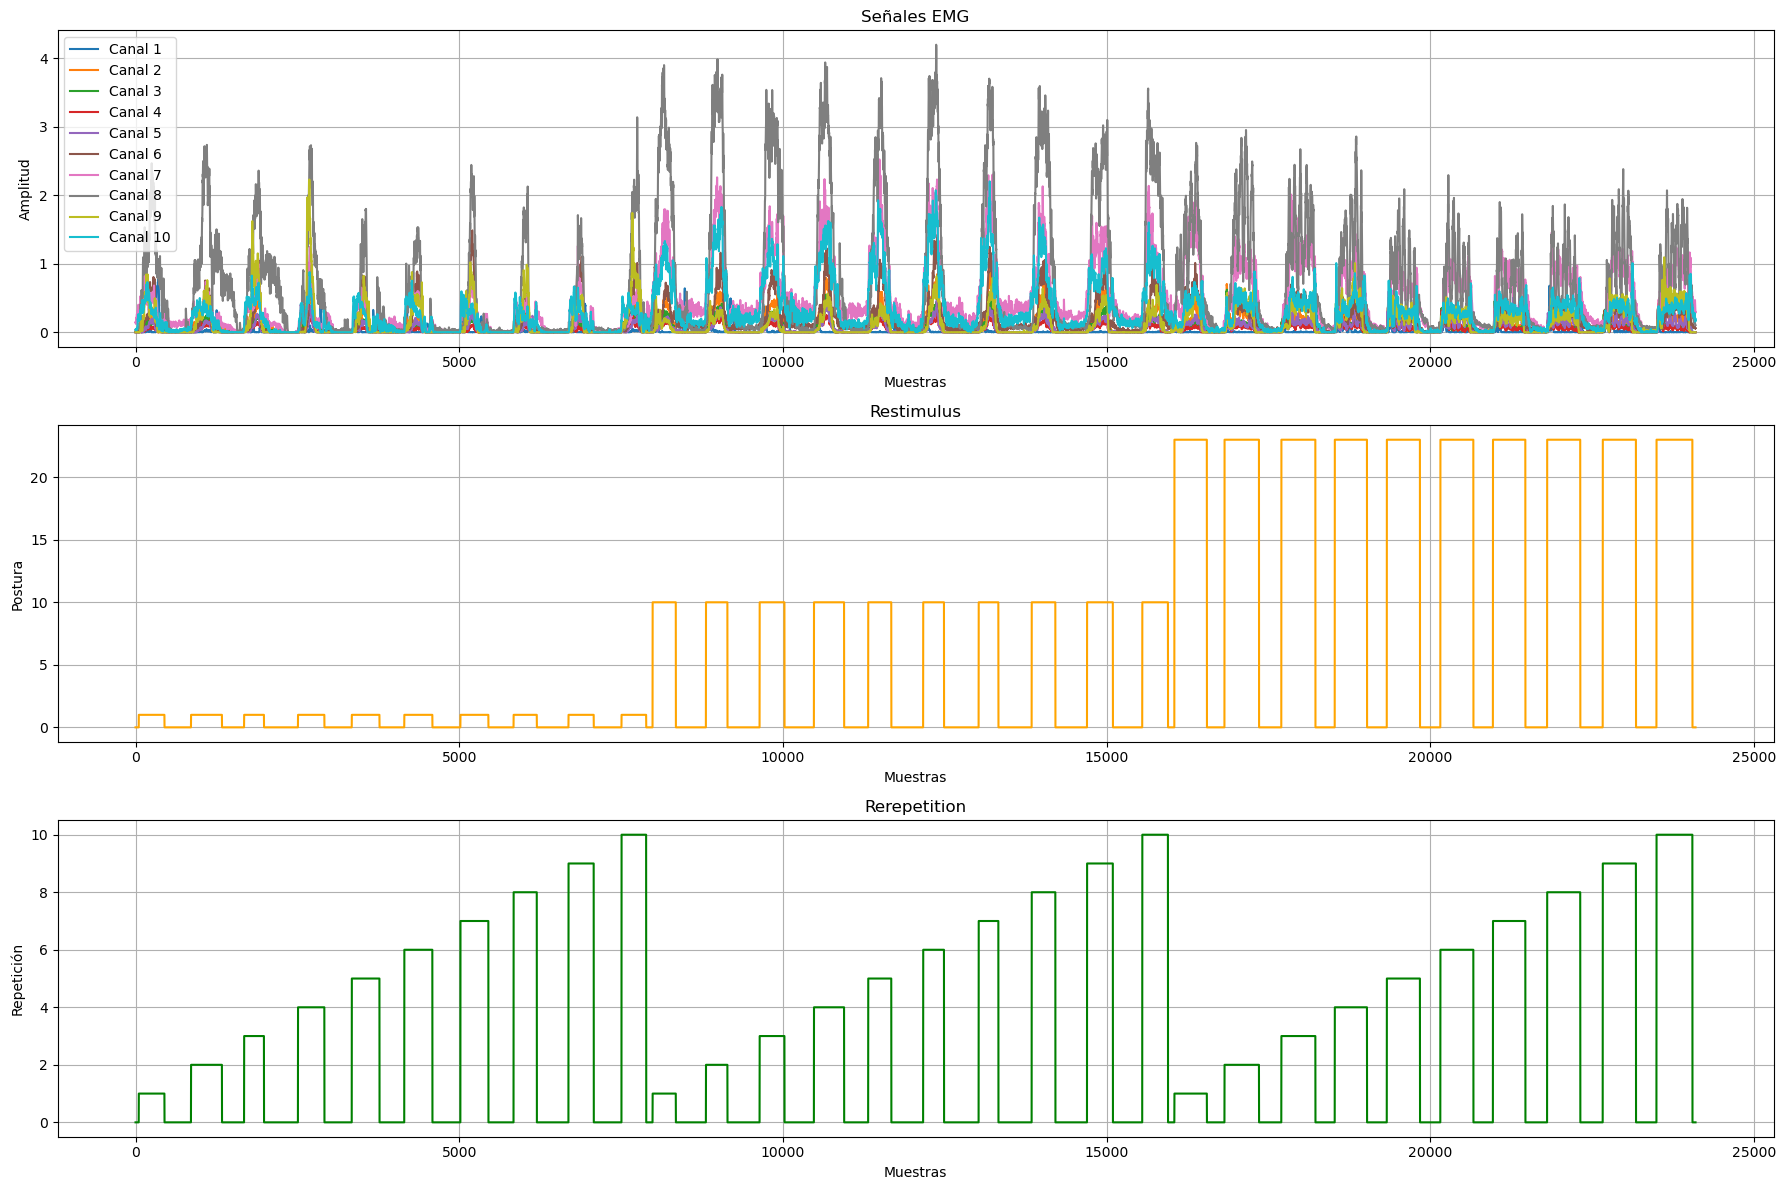

In [82]:
plt.figure(figsize=(18, 12))

# Subplot 1: EMG signals (first 10 columns)
plt.subplot(3, 1, 1)
for i in range(10):  # Iterate over the first 10 columns
    plt.plot(data_s1_ex_1_10_23[:, i], label=f'Canal {i+1}')
plt.title('Señales EMG')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

# Subplot 2: Restimulus (column 10)
plt.subplot(3, 1, 2)
plt.plot(data_s1_ex_1_10_23[:, 10], color='orange')
plt.title('Restimulus')
plt.xlabel('Muestras')
plt.ylabel('Postura')
plt.grid(True)

# Subplot 3: Rerepetition (column 11)
plt.subplot(3, 1, 3)
plt.plot(data_s1_ex_1_10_23[:, 11], color='green')
plt.title('Rerepetition')
plt.xlabel('Muestras')
plt.ylabel('Repetición')
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

> **Conclusión**
> 
> Al parecer el procedimiento funciona de acuerdo a lo que se espera de este.

### 4.3. Selección de los datos de las posturas para todos los sujetos del dataset

El el siguiente procedimiento se seleccionan las posturas de interes de todos los sujetos y se almacenan para analisis posteriores.

In [84]:
selected_exercises = [1, 23]  # Ejercicios seleccionados
data_for_selected_exercises = {}
for subject in data.keys():
    data_for_selected_exercises[subject] = get_samples_by_exercises(data[subject], selected_exercises)
    # Obtener muestras de los ejercicios seleccionados para cada sujeto
    print(f"Sujeto {subject}: {data_for_selected_exercises[subject].shape} muestras obtenidas para los ejercicios {selected_exercises}")

Sujeto 1: (16036, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 10: (15988, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 11: (16099, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 12: (15930, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 13: (16007, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 14: (15864, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 15: (15937, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 16: (16001, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 17: (16034, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 18: (15985, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 19: (16116, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 2: (15973, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 20: (15972, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 21: (16109, 12) muestras obtenidas para los ejercicios [1, 23]
Sujeto 22: (16003, 12)

In [85]:
len(data_for_selected_exercises)

27

Se realiza la verificación de los datos cargados con el sujeto de prueba para verificación del procedimiento con respecto a lo realizado al inicio.

In [86]:
INDEX_SUB

'1'

In [87]:
data_for_selected_exercises[INDEX_SUB].shape  # Mostrar la forma de los datos del primer sujeto

(16036, 12)

#### 4.4. Almacenamiento de los datos crudos a analizar

Los datos crudos a analizar se almacenarán en el directorio **`RAW_SUBSET_DATA_DIR`** siguiendo la nomenclatura `raw_subset_s{x}_p{1_2_*}_E3.npy`. Donde:
* **`s_{x}`**: Numero del sujeto.
* **`p_{nums}`**: Numero de las posturas seleccionadas.
* **`E3`**: Por que las posturas que se usan son las asociadas al ejercicio 3.

**Nota**: Se sobreentiende que la postura 0 va pues es asociada a la posición de descanso.

In [89]:
RAW_SUBSET_DATA_DIR

'./local/data/raw_subset'

In [90]:
selected_exercises

[1, 23]

Se realiza una inspección rapida de los datos antes de almacenarlos.

In [91]:
data_for_selected_exercises

{'1': array([[0.0024, 0.0024, 0.0024, ..., 0.0415, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.0464, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.0464, 0.    , 0.    ],
        ...,
        [0.0024, 0.0024, 0.0024, ..., 0.1904, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.1807, 0.    , 0.    ],
        [0.0024, 0.0024, 0.0024, ..., 0.1733, 0.    , 0.    ]]),
 '10': array([[0.2686, 0.1196, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.2588, 0.1074, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.2319, 0.0879, 0.0024, ..., 0.0024, 0.    , 0.    ],
        ...,
        [0.1636, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.1367, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ],
        [0.1123, 0.0024, 0.0024, ..., 0.0024, 0.    , 0.    ]]),
 '11': array([[0.0122, 0.0024, 0.0024, ..., 0.0562, 0.    , 0.    ],
        [0.0098, 0.0024, 0.0024, ..., 0.0537, 0.    , 0.    ],
        [0.0073, 0.0024, 0.0024, ..., 0.0537, 0.    , 0.    ],
        

Se procede a almacenar los datos

In [92]:
# Almacenar cada np.array en un archivo .npy
for idx, subject_data in data_for_selected_exercises.items():
    file_name = f"raw_subset_s{idx}_p{'_'.join(map(str, selected_exercises))}_E3.npy"
    file_path = os.path.join(RAW_SUBSET_DATA_DIR, file_name)
    np.save(file_path, subject_data)
    print(f"Archivo guardado: {file_path}")

Archivo guardado: ./local/data/raw_subset\raw_subset_s1_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s10_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s11_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s12_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s13_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s14_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s15_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s16_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s17_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s18_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s19_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s2_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s20_p1_23_E3.npy
Archivo guardado: ./local/data/raw_subset\raw_subset_s21_p1_23_E3.npy
Archivo guardado: ./lo

## Conclusiones

Al finalizar este notebook se logro.
* Seleccionar las posturas seleccionadas para los ejercicios 1 y 23 incluyendo los descansos.
* Almacenar estos datos para todos los sujetos para analisis posteriores.